<h1>The Bachelor First Impression Rose Permutation Test</h1>

The purpose of this script is to gather and clean data from the Bachelor Nation Wiki, create a subset of First Impression Rose recipients and a subset of random contestants from the same seasons, and then run a permutation test with these subsets to determine whether the first impression rose is statistically significant in extending contestant runs on The Bachelor.

In [3]:
import pandas as pd
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
pd.options.display.max_colwidth = 200
import numpy as np
import random
import matplotlib.pyplot as plt

We create a Selenium Web-Scraping Driver for Chrome.

In [4]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

We load the Bachelor Nation Wiki Seasons page with a timer to account for loading time.

In [5]:
page_url = 'https://bachelor-nation.fandom.com/wiki/Category:The_Bachelor_seasons'
driver.get(page_url)
time.sleep(3)

Find Season page links, put them in a list.

In [6]:
Bachelor_seasons = driver.find_elements(By.CLASS_NAME, 'category-page__member-link')
time.sleep(3)

In [7]:
seasons = []

In [8]:
for season in Bachelor_seasons:
    season_url = season.get_attribute('href')
    season_num = season.text
    seasons.append({'season_num': season_num, "url": season_url})

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

Iterate through season pages to collect contestant information. Print complete to notify when done.

In [9]:
contestant_list = []
for season in seasons:
    # go to season page
    driver.get(season['url'])
    #find contestants by class, add them to list
    contestant_elems = driver.find_elements(By.CLASS_NAME, 'lightbox-caption')
    time.sleep(3)
    for elem in contestant_elems:
        contestant_list.append({'season': season['season_num'],'contestant': elem.text})
print("complete")     

complete


In [10]:
#Create contestant dataframe, convert season column to string
contestants_df = pd.DataFrame(contestant_list)
contestants_df['season'] = contestants_df['season'].astype(str)

In [11]:
# remove seasons less than 9 and season 27
contestants_df = contestants_df.loc[contestants_df['season'] != 'The Bachelor (Season 2)']
contestants_df = contestants_df.loc[contestants_df['season'] != 'The Bachelor (Season 3)']
contestants_df = contestants_df.loc[contestants_df['season'] != 'The Bachelor (Season 6)']
contestants_df = contestants_df.loc[contestants_df['season'] != 'The Bachelor (Season 27)']

In [12]:
#remove non-contestant scraped elements (ring pics)
contestants_df = contestants_df[contestants_df['contestant'].str.contains('\n')]

In [13]:
#Create Dictionary of First Impression Rose Recipients, excluding outlier Season 17
bachelor_firr_dict = {9:'Lisa Blank', 10:'Stephanie Tipper', 11:'Jenni Croft', 12:'Amanda Rantuccio', 13:'Nikki Kaapke',
             14:'Tenley Molzahn', 15:'Ashley Spivey', 16:'Lindzi Cox', 18: 'Sharleen Joynt', 19:'Britt Nilsson',
             20:'Olivia Caridi', 21:'Rachel Lindsay', 22:'Chelsea Roy', 23:'Hannah Godwin', 24:'Hannah Sluss',
             25:'Abigail Heringer', 26:'Teddi Wright'}

In [14]:
#Dictionary to make seasons bite-size
season_dict = {'The Bachelor (Season 9)':'9',
               'The Bachelor (Season 10)':'10',
               'The Bachelor (Season 11)':'11',
               'The Bachelor (Season 12)':'12',
               'The Bachelor (Season 13)':'13',
               'The Bachelor (Season 14)':'14',
               'The Bachelor (Season 15)':'15',
               'The Bachelor (Season 16)':'16',
               'The Bachelor (Season 17)':'17',
               'The Bachelor (Season 18)':'18',
               'The Bachelor (Season 19)':'19',
               'The Bachelor (Season 20)':'20',
               'The Bachelor (Season 21)':'21',
               'The Bachelor (Season 22)':'22',
               'The Bachelor (Season 23)':'23',
               'The Bachelor (Season 24)':'24',
               'The Bachelor (Season 25)':'25',
               'The Bachelor (Season 26)':'26'}

In [15]:
#dictionary to convert which week contestant was eliminated into a number
end_dict = {'week 1':1,
            'week 2':2,
            'week 3':3,
            'week 4':4,
            'week 5':5,
            'week 6':6,
            'week 7':7,
            'week 8':8,
            'week 9':9,
            'Winner':10,
            'Runner':10}

In [16]:
#create index for number of lines in contestant text profiles
contestants_df['idx'] = contestants_df['contestant'].str.count('\n')

In [17]:
#correct outlier contestant profiles with extra info
contestants_df.loc[contestants_df.contestant.str.contains('Jordan Branch'), 'contestant'] = 'Jordan Branch\n24\nWindsor, Colorado\nStudent\nEliminated in week 2'
contestants_df.loc[contestants_df.contestant.str.contains('Kimberly Sherbach'), 'contestant'] = 'Kimberly Sherbach\n28\nWantagh, New York\nYoga Instructor\nEliminated in week 1'
contestants_df.loc[contestants_df.contestant.str.contains('Cassie Randolph'), 'contestant'] = 'Cassie Randolph\n23\nHuntington Beach, California\nSpeech pathologist\nWinner'
contestants_df.loc[contestants_df.contestant.str.contains('Alayah Benavidez'), 'contestant'] = 'Alayah Benavidez\n24\nSan Antonio, Texas\nMiss Texas 2019\nEliminated in week 3'
contestants_df.loc[contestants_df.contestant.str.contains('Susie Evans'), 'contestant'] = 'Susie Evans\n28\nWedding Videographer\nPoquoson, Virginia\nWinner'

In [18]:
#separate text into multiple columns. Lessons learned = use copies of dataframes and break down long equations to base elements to find errors
cdf_final = contestants_df.copy()
cdf_final[['Name', 'Age','Hometown','Occupation','End']] = contestants_df.contestant.str.split('\n', expand=True)

In [19]:
#fix nickname entries
cdf_final.loc[cdf_final.contestant.str.contains('Nicole "Nikki" Kaapke'), 'Name'] = 'Nikki Kaapke'
cdf_final.loc[cdf_final.contestant.str.contains('Lindsey "Lindzi" Cox'), 'Name'] = 'Lindzi Cox'


In [20]:
#Permutation function
def perm_fun(data, dict1, dict2):
    #combines contestants into one list
    total_list = list(dict1.values()) + list(dict2.values())
    random.shuffle(total_list)
    fake_keys = list(range(0, 17))
    perm1 = {fake_keys[i]:total_list[:17][i] for i in range(len(fake_keys))}
    perm2 = {fake_keys[i]:total_list[17:][i] for i in range(len(fake_keys))}
    return abs(week_mean(data, perm1) - week_mean(data,perm2))


In [21]:
#function for converting Elimination status to integers
def convert_end(data, conv_dict):
    clone_data = data.copy()
    for idx, row in clone_data.iterrows():
        end = row.End
        for key, value in conv_dict.items():
            if type(end) == int:
                continue
            elif key in end:
                clone_data.at[idx, 'End'] = value
    return clone_data

In [22]:
#Map dictionaries to make dataframe easier to use, remove contestants eliminated in Week 1
test_array = pd.array([10])
cdf_final = cdf_final.replace({'season':season_dict})
cdf_final_sub = cdf_final[cdf_final['End'] != 1]
final_df = convert_end(cdf_final_sub, end_dict)

In [23]:
#function to calculate the average weeks lasted by one group of contestants
def week_mean(data, group_dict):
    total = []
    for key, value in group_dict.items():
        total.append(data.loc[data['Name'] == value, 'End'].item())
    return np.mean(total)


In [24]:
# function to create list of the week each contestant of group was eliminated
def week_total(data, group_dict):
    total = []
    for key, value in group_dict.items():
        total.append(data.loc[data['Name'] == value, 'End'].item())
    return total

In [25]:
#Function to create Control Group of Random contestants
def test_group(data,group_dict):
    random_dict = group_dict.copy()
    for key, value in random_dict.items():
        season_cont = data.loc[data['season'] == str(key)]
        season_cont = season_cont.loc[season_cont['Name'] != value]
        random_dict[key] = season_cont.Name.sample().item()
    return random_dict
        

In [26]:
#Calculate Average Weeks Lasted for First Impression Rose Recipients
firr_mean = week_mean(final_df, bachelor_firr_dict)
firr_mean

7.176470588235294

In [27]:
#Create Control Group of Random Contestants excluding FIRR
control_group = test_group(final_df, bachelor_firr_dict)
control_mean = week_mean(final_df, control_group)
control_mean

3.8823529411764706

In [28]:
#Calculate Observed Difference between FIRR and Control Group
ground_truth = abs(firr_mean - control_mean)
ground_truth

3.294117647058824

In [29]:
#Create Bar Chart to illustrate Average Weeks Lasted Differences between First Impression Rose Recipient and Control Groups
bar_dict = {'FIRRs':firr_mean, 'Control': control_mean, 'Observed Difference':ground_truth}

Text(0.5, 1.0, 'Average Weeks Lasted')

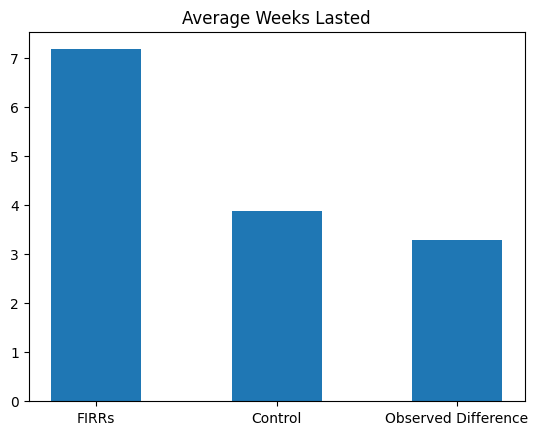

In [30]:
plt.bar(range(len(bar_dict)), list(bar_dict.values()), tick_label=list(bar_dict.keys()), width=.5)
plt.title('Average Weeks Lasted')

In [31]:
#Run Permutation Test
perm_diffs = [perm_fun(final_df, bachelor_firr_dict, control_group) for _ in range(1000)]

In [32]:
#Calculate P Value
np.mean([diff > ground_truth for diff in perm_diffs])

0.0

Text(0, 0.5, 'Number of Permutations')

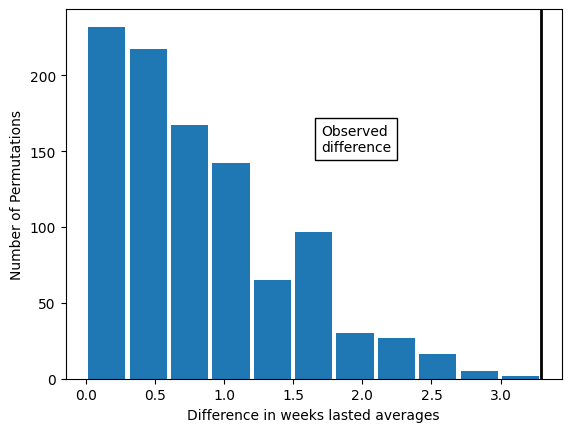

In [33]:
#Create Histograph to illustrate Permutation Test
plt.hist(perm_diffs, bins=11, rwidth=0.9)
plt.axvline(x = ground_truth, color='black', lw=2)
plt.text(1.7, 150, 'Observed\ndifference', bbox={'facecolor':'white'})
plt.xlabel('Difference in weeks lasted averages')
plt.ylabel('Number of Permutations')

In [34]:
#Create First Impression Rose Recipient List for Horizontal Bar Graph
firr_list = list(bachelor_firr_dict.values())

In [35]:
#Create dataframe for Horizontal Bar Graph
barh_subset = final_df.loc[final_df['Name'].isin(firr_list)]


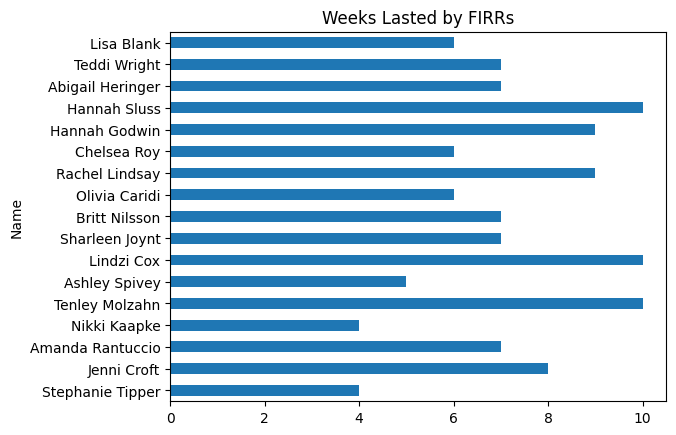

In [53]:
#Create Horizontal Bar Graph for Weeks Lasted by First Impression Rose Recipients.
ax = barh_subset.plot.barh(x='Name', y='End')
plt.title('Weeks Lasted by FIRRs')
plt.legend().remove()